**CliniScan:Lung-Abnormality Detection on Chest X‑rays using AI**

**1-DICOM to PNG Conversion Utility**

In [1]:
# Install dependencies
%pip install pydicom
!pip install grad-cam
import os
import cv2
import pydicom
import pandas as pd


def dicom_to_png(dicom_path: str, png_path: str) -> bool:
    """Convert a single DICOM file to PNG format."""
    try:
        ds = pydicom.dcmread(dicom_path)
        img = ds.pixel_array

        # Normalize pixel values to 0–255 and convert to uint8
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype("uint8")

        cv2.imwrite(png_path, img_uint8)
        return True
    except Exception as e:
        print(f"❌ Failed to convert {dicom_path}: {e}")
        return False


def convert_dataset(dicom_dir: str, output_dir: str, annotations_csv: str):
    """Batch convert DICOM dataset to PNG using annotations."""
    os.makedirs(output_dir, exist_ok=True)
    annotations = pd.read_csv(annotations_csv)

    for _, row in annotations.iterrows():
        dicom_file = os.path.join(dicom_dir, f"{row['image_id']}.dicom")
        png_file = os.path.join(output_dir, f"{row['image_id']}.png")

        if os.path.exists(dicom_file):
            if dicom_to_png(dicom_file, png_file):
                print(f"✅ Converted: {dicom_file} → {png_file}")
        else:
            print(f"⚠️ Missing file: {dicom_file}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5c251defd1ba1d2a17dadeb183616933bcfe81495060cc78db117988a28c10de
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


**2-Custom Dataset Class (VinDr-CXR)**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import cv2
from PIL import Image

class VinDrCXRDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, task='classification'):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.task = task

        self.labels = sorted(df['label'].unique())
        self.label_to_id = {label: i for i, label in enumerate(self.labels)}

        self.grouped_images = self.df.groupby('image_id')
        self.image_ids = list(self.grouped_images.groups.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        annotations = self.grouped_images.get_group(img_id)

        if self.task == 'classification':
            label_vector = torch.zeros(len(self.labels), dtype=torch.float)
            for _, row in annotations.iterrows():
                label_vector[self.label_to_id[row['label']]] = 1.0

            if self.transform:
                image = self.transform(image)

            return image, label_vector

        elif self.task == 'detection':
            boxes, labels = [], []
            for _, row in annotations.iterrows():
                boxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
                labels.append(self.label_to_id[row['label']])

            target = {
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)
            }

            if self.transform:
                image = self.transform(image)

            return image, target


**3-ResNet18 Classifier (Transfer Learning)**

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        # Modify the final fully connected layer for your number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

if __name__ == "__main__":
    num_classes = 5 # Example number of classes
    model = ResNetClassifier(num_classes)

    # Check model output
    dummy_input = torch.randn(1, 3, 256, 256)
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


Model output shape: torch.Size([1, 5])


**4.Google Drive Mount & Dataset Extraction**

In [4]:
import zipfile, os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

zip_path = "/content/drive/MyDrive/Copy of Train.zip"
extract_path = "/content/dataset"

# Extract dataset if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset extracted to: {extract_path}")
else:
    print(f"ℹ️ Dataset already exists at: {extract_path}")

# Show dataset structure (first 40 lines)
print("📂 Dataset structure (first 40 lines):")
!ls -R /content/dataset | head -40


Mounted at /content/drive
✅ Dataset extracted to: /content/dataset
📂 Dataset structure (first 40 lines):
/content/dataset:
chest_xray

/content/dataset/chest_xray:
chest_xray
__MACOSX
test
train
val

/content/dataset/chest_xray/chest_xray:
test
train
val

/content/dataset/chest_xray/chest_xray/test:
NORMAL
PNEUMONIA

/content/dataset/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg
IM-0013-0001.jpeg
IM-0015-0001.jpeg
IM-0016-0001.jpeg
IM-0017-0001.jpeg
IM-0019-0001.jpeg
IM-0021-0001.jpeg
IM-0022-0001.jpeg
IM-0023-0001.jpeg
IM-0025-0001.jpeg
IM-0027-0001.jpeg


**5-YOLOv8 Setup, Dataset Preparation & Training**

In [5]:
# Install YOLOv8
!pip install ultralytics --quiet

import os
import random
import torch
import zipfile
import shutil
from ultralytics import YOLO
from google.colab import drive

# Check PyTorch & GPU
print("✅ Torch version:", torch.__version__)
print("✅ GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ GPU name:", torch.cuda.get_device_name(0))

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Dataset paths
zip_path = "/content/drive/MyDrive/Copy of Train.zip"
extract_path = "/content/dataset"

# Extract dataset if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset extracted to {extract_path}")
else:
    print("ℹ️ Dataset already available.")

# Define paths for the original dataset structure
original_train_dir = os.path.join(extract_path, "chest_xray", "chest_xray", "train")
original_val_dir = os.path.join(extract_path, "chest_xray", "chest_xray", "val")

# Define paths for the new YOLOv8 classification structure
yolo_data_dir = os.path.join(extract_path, "yolov8_classification")
yolo_train_dir = os.path.join(yolo_data_dir, "train")
yolo_val_dir = os.path.join(yolo_data_dir, "val")

# Create the new YOLOv8 structure
os.makedirs(yolo_train_dir, exist_ok=True)
os.makedirs(yolo_val_dir, exist_ok=True)

# Function to copy images to the new structure
def copy_images(source_dir, target_dir):
    for class_name in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_name)
        # Add this check to skip non-directory entries like .DS_Store
        if not os.path.isdir(class_source_dir):
            continue
        class_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_target_dir, exist_ok=True)
        for img_name in os.listdir(class_source_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy(os.path.join(class_source_dir, img_name), os.path.join(class_target_dir, img_name))


# Copy training and validation images
copy_images(original_train_dir, yolo_train_dir)
copy_images(original_val_dir, yolo_val_dir)


print("✅ Dataset reorganized for YOLOv8 classification.")

# Show dataset structure (first 40 lines)
print("📂 Dataset structure (first 40 lines):")
!ls -R {yolo_data_dir} | head -40

# Load pretrained YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")

# Train the model
model.train(
    data=yolo_data_dir,  # path with train/ and val/
    epochs=20,
    imgsz=224,
    batch=32,
    name="classification_model_fixed"
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Torch version: 2.8.0+cu126
✅ GPU available: False
Mounted at /content/drive
ℹ️ Dataset already available.
✅ Dataset reorganized for YOLOv8 classification.
📂 Dataset structure (first 40 lines):
/content/dataset/yolov8_classification:
train
val

/content/dataset/yolov8_classification/train:
NORMAL
PNEUMONIA

/content/dataset/yolov8_classification/train/NORMAL:
IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg
IM-0135-0001.jpeg
IM-0137-0001.jpeg
IM-0140-0001.jpeg
IM-0141-0001.jp

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca464749970>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('/content/runs/classify/classification_model_fixed')
speed: {'preprocess': 0.00200062498834086, 'inference': 7.9740262499967685, 'loss': 8.056252909227624e-05, 'postprocess': 0.0001925000105984509}
task: 'classify'
top1: 1.0
top5: 1.0

**6-Grad-CAM Setup & Visualization**

Predicted class: PNEUMONIA (58.48%)


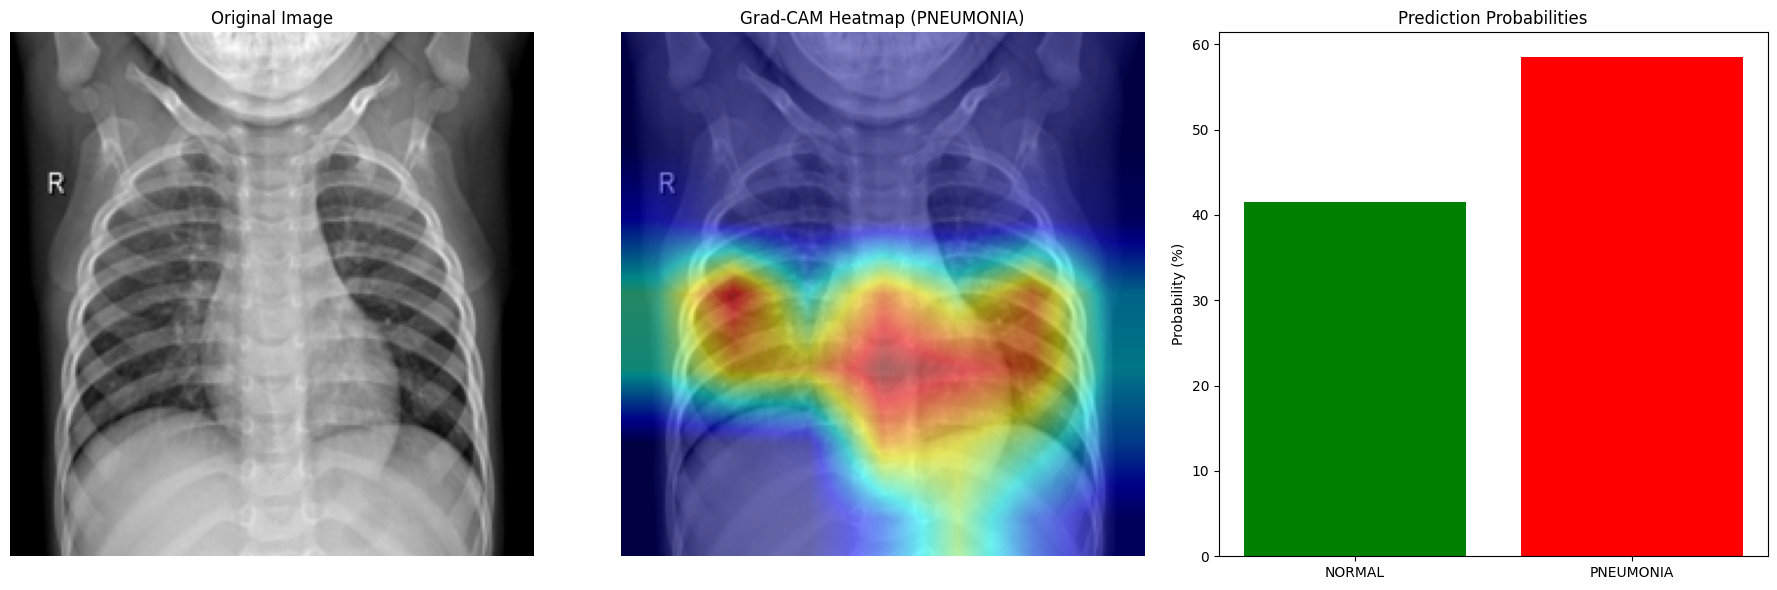

('PNEUMONIA', 58.479201793670654)

In [6]:
# ===================================================================
# X-RAY PREDICTION + GRAD-CAM VISUALIZATION
# ===================================================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -----------------------------
# Load your model
# -----------------------------
from __main__ import ResNetClassifier  # replace if needed

num_classes = 2   # NORMAL, PNEUMONIA
class_names = ["NORMAL", "PNEUMONIA"]

model = ResNetClassifier(num_classes)
# model.load_state_dict(torch.load("model.pth", map_location="cpu"))  # uncomment when trained model is available
model.eval()

# -----------------------------
# Preprocessing
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -----------------------------
# Prediction + Grad-CAM Function
# -----------------------------
def predict_and_visualize(image_path):
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    # Original image for overlay
    rgb_img = np.array(img.resize((224, 224))) / 255.0

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)[0]

    pred_class = torch.argmax(probs).item()
    confidence = probs[pred_class].item() * 100

    print(f"Predicted class: {class_names[pred_class]} ({confidence:.2f}%)")

    # -------------------------
    # Grad-CAM
    # -------------------------
    target_layers = [model.model.layer4[-1]]  # last conv block
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=[ClassifierOutputTarget(pred_class)])[0]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # -------------------------
    # Plot Results
    # -------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Image
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Grad-CAM
    axes[1].imshow(cam_image)
    axes[1].set_title(f"Grad-CAM Heatmap ({class_names[pred_class]})")
    axes[1].axis("off")

    # Probability Distribution
    axes[2].bar(class_names, probs.numpy() * 100, color=["green", "red"])
    axes[2].set_ylabel("Probability (%)")
    axes[2].set_title("Prediction Probabilities")

    plt.tight_layout()
    plt.show()

    return class_names[pred_class], confidence

# -----------------------------
# Example Run
# -----------------------------
image_path = "/content/dataset/chest_xray/chest_xray/train/NORMAL/IM-0129-0001.jpeg"
predict_and_visualize(image_path)


**7.DEPLOYMENT**

In [11]:
!pip install --quiet streamlit torch torchvision plotly pyngrok opencv-python-headless pydicom
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.7 MB/s eta 0:00:00
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-mp2zur92
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-mp2zur92
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import io
import plotly.express as px

# Optional Grad-CAM imports
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    GRADCAM_AVAILABLE = True
except:
    GRADCAM_AVAILABLE = False

# ----------------- Model -----------------
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        return self.model(x)

@st.cache_resource
def load_model():
    model = ResNetClassifier()
    try:
        model.load_state_dict(torch.load("model.pth", map_location="cpu"))
        st.success("✅ Trained model loaded.")
    except:
        st.warning("`model.pth` not found. Using default ResNet18.")
    model.eval()
    return model

model = load_model()

# ----------------- Preprocessing -----------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ----------------- DICOM Handling -----------------
def dicom_to_pil(dcm_bytes):
    import pydicom, cv2
    ds = pydicom.dcmread(io.BytesIO(dcm_bytes))
    arr = ds.pixel_array
    arr = cv2.normalize(arr,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    if arr.ndim==2:
        return Image.fromarray(arr).convert("RGB")
    return Image.fromarray(arr).convert("RGB")

# ----------------- UI -----------------
st.title("🩻 Chest X-Ray Classification + Grad-CAM")
uploaded_file = st.file_uploader("Upload an image or DICOM (.dcm)", type=["jpg","jpeg","png","dcm"])

if uploaded_file:
    try:
        # Load image
        if uploaded_file.name.endswith(".dcm"):
            img = dicom_to_pil(uploaded_file.getvalue())
        else:
            img = Image.open(io.BytesIO(uploaded_file.getvalue())).convert("RGB")
        st.image(img, caption="Uploaded Image", use_column_width=True)

        # Preprocess
        inp = transform(img).unsqueeze(0)
        with torch.no_grad():
            out = model(inp)
            probs = torch.softmax(out, dim=1)[0]
            pred_class = torch.argmax(probs).item()

        class_names = ["Normal","Pneumonia"]
        st.subheader(f"Prediction: **{class_names[pred_class]}**")
        st.write(f"Confidence: {probs[pred_class].item()*100:.2f}%")

        st.subheader("Class Probabilities")
        chart_data = {class_names[i]: probs[i].item() for i in range(len(class_names))}
        st.bar_chart(chart_data)

        # ----------------- Grad-CAM -----------------
        if GRADCAM_AVAILABLE:
            st.subheader("🔥 Grad-CAM Visualization")
            if hasattr(model, "model"):
                target_layers = [model.model.layer4[-1]]
            else:
                target_layers = [model.layer4[-1]]

            cam = GradCAM(model=model, target_layers=target_layers)
            rgb_img = np.array(img.resize((224,224)))/255.0
            grayscale_cam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(pred_class)])[0]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            col1, col2 = st.columns(2)
            with col1:
                st.image(img, caption="Original X-ray", width=350)
            with col2:
                st.image(visualization, caption="Grad-CAM", width=350)

    except Exception as e:
        st.error(f"Error: {e}")


Overwriting app.py


In [15]:
# Ngrok setup
from pyngrok import ngrok
import subprocess
import time

PORT = 8501

# Run Streamlit in background
!streamlit run app.py &>/dev/null &

# Give Streamlit some time to start
time.sleep(5)

# Connect Ngrok
public_url = ngrok.connect(PORT)
public_url


<NgrokTunnel: "https://imperatival-inconvincibly-milly.ngrok-free.dev" -> "http://localhost:8501">

**7-Deployment**